In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [2]:
# Load and clean dataset
df = pd.read_csv("heart_failure.csv")
df = df.copy()
df.loc[df['Cholesterol'] == 0, 'Cholesterol'] = np.nan
df.loc[df['RestingBP'] == 0, 'RestingBP'] = np.nan
df['Cholesterol'] = df['Cholesterol'].fillna(df['Cholesterol'].median())
df['RestingBP'] = df['RestingBP'].fillna(df['RestingBP'].median())

In [3]:
# Dataset Information
print("Dataset Info:")
print(df.info())
print("\nFirst Five Rows:")
print(df.head())
print("\nMissing Values in Each Column:")
print(df.isnull().sum())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    float64
 4   Cholesterol     918 non-null    float64
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 86.2+ KB
None

First Five Rows:
   Age Sex ChestPainType  RestingBP  Cholesterol  FastingBS RestingECG  MaxHR  \
0   40   M           ATA      140.0        289.0          0     Normal    172   
1  

In [4]:
# Feature Engineering
df['AgeGroup'] = pd.cut(df['Age'], bins=[0, 40, 60, 100], labels=['Young', 'Middle', 'Senior'])
df['BP_Zero'] = (df['RestingBP'] == 0).astype(int)
df['Chol_Zero'] = (df['Cholesterol'] == 0).astype(int)
df = pd.get_dummies(df, drop_first=True)

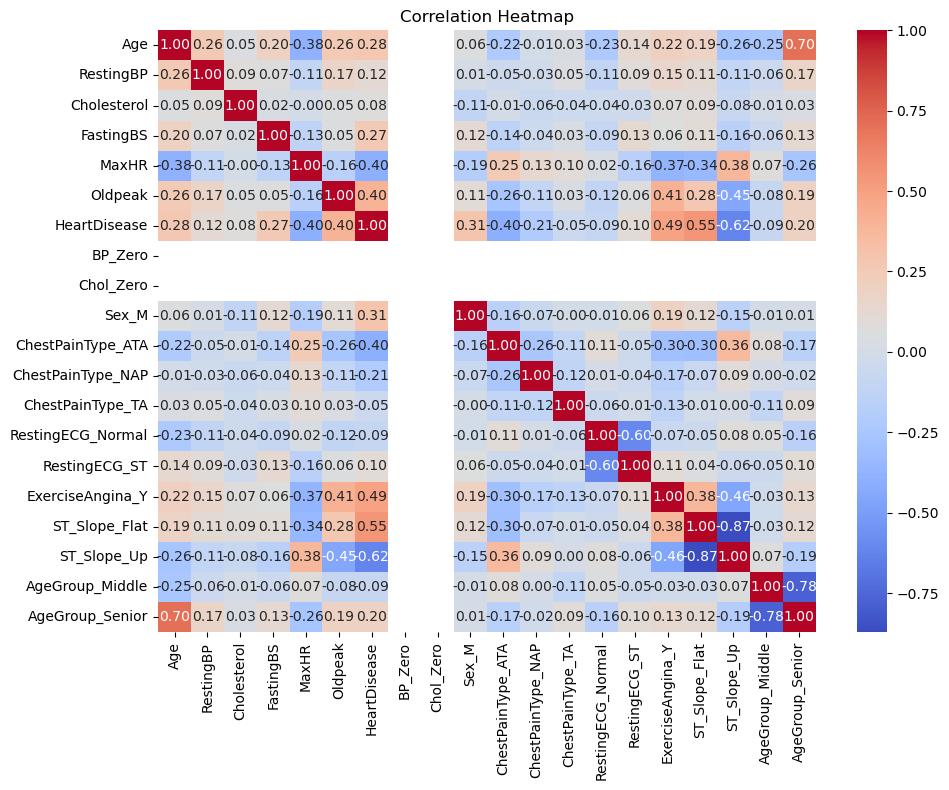

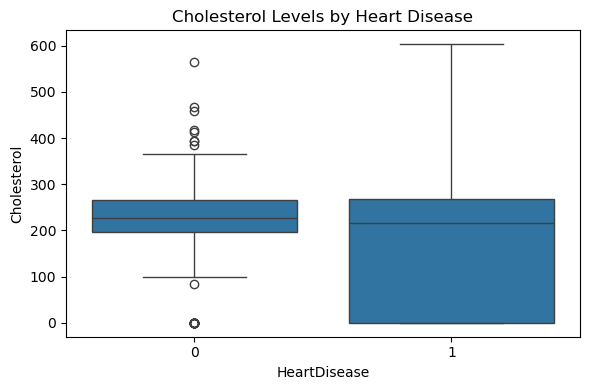

In [5]:
# Visualizations
os.makedirs("visuals", exist_ok=True)

plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.savefig("visuals/correlation_heatmap.png")
plt.show()
plt.close()

plt.figure(figsize=(6, 4))
sns.boxplot(x='HeartDisease', y='Cholesterol', data=pd.read_csv("heart_failure.csv"))
plt.title("Cholesterol Levels by Heart Disease")
plt.tight_layout()
plt.savefig("visuals/cholesterol_boxplot.png")
plt.show()
plt.close()

In [6]:
# ML Model
X = df.drop('HeartDisease', axis=1)
y = df['HeartDisease']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

models = {
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier(),
    'SVM': SVC(),
    'KNN': KNeighborsClassifier()
}

results = {}
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    results[name] = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1': f1_score(y_test, y_pred)
    }


Model Performance Metrics:
                     Accuracy  Precision    Recall        F1
Logistic Regression  0.853261   0.900000  0.841121  0.869565
Random Forest        0.858696   0.885714  0.869159  0.877358
SVM                  0.853261   0.892157  0.850467  0.870813
KNN                  0.836957   0.888889  0.822430  0.854369


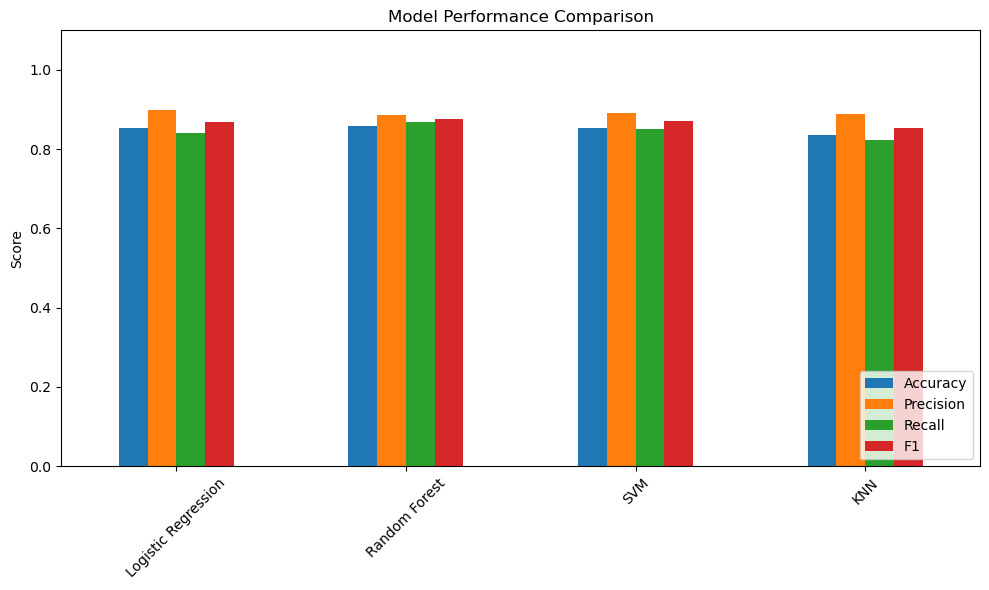

In [7]:
# Model Performance Visualization
results_df = pd.DataFrame(results).T
print("\nModel Performance Metrics:")
print(results_df)

results_df.plot(kind='bar', figsize=(10, 6))
plt.title("Model Performance Comparison")
plt.ylabel("Score")
plt.ylim(0, 1.1)
plt.xticks(rotation=45)
plt.legend(loc='lower right')
plt.tight_layout()
plt.savefig("visuals/model_performance_comparison.png")
plt.show()
plt.close()

In [8]:
# Hyperparameter Tuning for Random Forest
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5]
}
grid_search = GridSearchCV(RandomForestClassifier(), param_grid, cv=3, scoring='accuracy')
grid_search.fit(X_train_scaled, y_train)
best_model = grid_search.best_estimator_
y_pred_final = best_model.predict(X_test_scaled)
final_cm = confusion_matrix(y_test, y_pred_final)

print("\nConfusion Matrix for Best Model:")
print(final_cm)


Confusion Matrix for Best Model:
[[65 12]
 [14 93]]


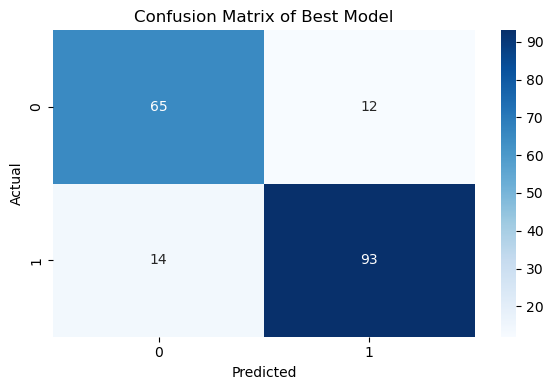

In [9]:
# Confusion Matrix Visualization
plt.figure(figsize=(6, 4))
sns.heatmap(final_cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix of Best Model')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.savefig("visuals/confusion_matrix_best_model.png")
plt.show()
plt.close()